This notebook explores Russia's greatest comedy *Woe from Wit*.

In [1]:
import numpy as np
import re
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import json
import pandas as pd

In [2]:
with open('TEI_files/R_18.xml', 'r') as file:
    soup = bs(file, 'lxml')

In [3]:
def combine_verse_lines(soup):
    verses = soup.find_all('l')
    only_verses = ''
    for verse in verses:
        only_verses+=str(verse)
    splits = re.split('<l>|<l part="I"|<l type="interscene">|<l part="I" type="interscene">', only_verses)
    verse_lines = []
    symbols = ['</l>', '<l part=', '\"', 'I', 'M', 'F', '>', '<l type=interscene']
    for split in splits[1:]:
        for symbol in symbols:
            split = split.replace(symbol, '')
        verse_lines.append(split)
        
    return verse_lines

In [4]:
def count_syllables(verse_lines):
    number_syllables = []
    for line in verse_lines:
        vowel_count= 0 
        for vowel in ['а', 'е', 'ё', 'и', 'о', 'у', 'э', 'ю', 'я']:
            vowel_count+=line.lower().count(vowel)
        number_syllables.append(vowel_count)
        
    return number_syllables

In [5]:
verse_lines = combine_verse_lines(soup)

In [6]:
len(verse_lines)

2220

In [7]:
number_syllables = count_syllables(verse_lines)

In [8]:
len(number_syllables)

2220

In [9]:
np.sum(number_syllables)

22076

In [10]:
np.sum(number_syllables) / 12.5

1766.08

In [11]:
np.sum(number_syllables) / 2219

9.94862550698513

In [12]:
np.mean(number_syllables)

9.944144144144143

In [13]:
print(len([num for num in number_syllables if num ==8]))
print(len([num for num in number_syllables if num ==9]))
print(len([num for num in number_syllables if num ==10]))
print(len([num for num in number_syllables if num ==11]))
print(len([num for num in number_syllables if num ==12]))
print(len([num for num in number_syllables if num ==13]))

428
277
248
328
439
252


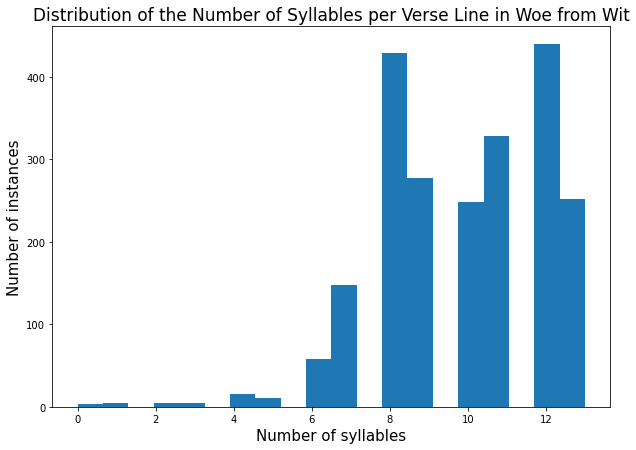

In [14]:
plt.figure(figsize=(10, 7))
plt.title('Distribution of the Number of Syllables per Verse Line in Woe from Wit', fontsize=17)
plt.hist(number_syllables, bins=20)
plt.xlabel('Number of syllables', fontsize=15)
plt.ylabel('Number of instances', fontsize=15)
plt.show()

In [15]:
22076 / 12.5

1766.08

In [16]:
9.95 / 12.5

0.7959999999999999

In [17]:
((9.95 / 12.5) * 2219)

1766.3239999999998

In [18]:
# divide the total number of utterances by the scaled number of verse lines
698 / (2219 * 0.8)

0.393195132942767

## Identify Monologues

In [19]:
# load Woe from Wit data
with open('Test/R_18.json') as f:
    woe = json.load(f)

In [20]:
indices_non_monoloque = []
for act_num, act in enumerate(woe['play_summary'].keys(), 0):
    for num, scene in enumerate(woe['play_summary'][act].keys(), 0):
        if woe['play_summary'][act][scene]['num_speakers'] > 1:
            indices_non_monoloque.append((act_num, num))

In [21]:
acts = soup.find_all('div', {'type': 'act'})

In [22]:
non_monologues = []
for index in indices_non_monoloque:
    scene = acts[index[0]].find_all('div', {'type': ['scene', 'extra_scene', 'complex_scene']})[index[1]]
    non_monologues.append(scene)

In [23]:
len(non_monologues)

53

In [24]:
74 - 53

21

In [25]:
len(indices_non_monoloque)

53

## Create Text Only From Non-Monolgues

In [26]:
all_non_monologues = ''
for item in non_monologues:
    all_non_monologues += str(item)

In [27]:
non_monoloue_verse_lines = combine_verse_lines(bs(all_non_monologues))

In [28]:
number_syllables_non_monologue = count_syllables(non_monoloue_verse_lines)

In [29]:
# remove incorrect noise that was introduced through removing monologic scenes
number_syllables_non_monologue = [i for i in number_syllables_non_monologue if i <14]

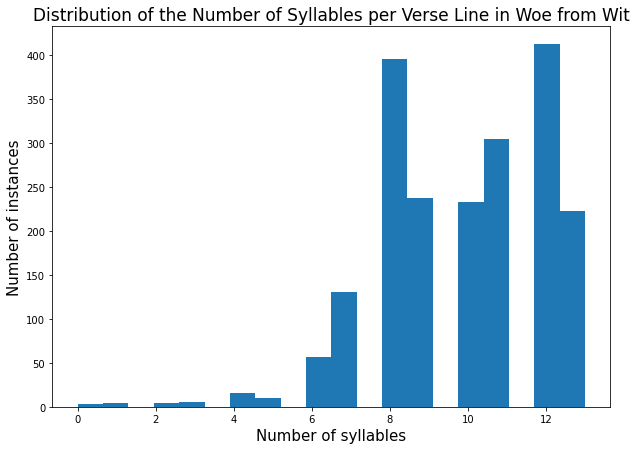

In [30]:
plt.figure(figsize=(10, 7))
plt.title('Distribution of the Number of Syllables per Verse Line in Woe from Wit', fontsize=17)
plt.hist(number_syllables_non_monologue, bins=20)
plt.xlabel('Number of syllables', fontsize=15)
plt.ylabel('Number of instances', fontsize=15)
plt.show()

In [31]:
np.mean(number_syllables_non_monologue)

9.936086529006882

In [32]:
9.95 / 12.5

0.7959999999999999

In [33]:
(len(number_syllables_non_monologue)  * .8)

1627.2

In [34]:
total_number_utterances = 0
for scene in non_monologues:
    total_number_utterances += len(scene.find_all('speaker'))

In [35]:
total_number_utterances / (len(number_syllables_non_monologue)  * .8)

0.41482300884955753

## Conclusion

The low vivacity does not seem to be caused by the higher than usual number of monologues. In non-monologues, dialogue vivacity is only slightly higher.

## Check Vivacity by Character

In [36]:
in_text_names = ['chatskij', 'sofija', 'famusov', 'molchalin', 'lizanka', 'skalozub', 'repetilov', 'zagoretskij']

In [37]:
distribution_by_character = {}
for name in in_text_names:
    this_speaker = soup.find_all('sp', {'who': '#{}'.format(name)})
    number_utterances = len(this_speaker)
    one_string = ''
    for item in this_speaker:
        one_string += str(item)
    verse_lines = combine_verse_lines(bs(one_string))
     # remove noise that was possibly introduced by combining utterances from different scenes
    number_syllables = [val for val in  count_syllables(verse_lines) if val <= 13]
    distribution_by_character[name] = (number_utterances, number_syllables)

In [38]:
distribution_by_character.keys()

dict_keys(['chatskij', 'sofija', 'famusov', 'molchalin', 'lizanka', 'skalozub', 'repetilov', 'zagoretskij'])

In [39]:
def vivacity_by_character(data_dict, character):
    print(character)
    average_length_verse = round(np.mean(data_dict[character][1]), 3)
    scaled_number_verse_lines = round(len(data_dict[character][1]) * (average_length_verse / 12.5), 3)
    #print(scaled_number_verse_lines)
    number_utterances = data_dict[character][0]
    print('Number of utterances:', number_utterances)
    average_lengh_utterance = round(scaled_number_verse_lines/number_utterances , 3)
    vivacity = round(number_utterances / scaled_number_verse_lines, 3)
    print('Coefficient of dialogue vivacity:', vivacity)
    print('Average utterance length (in verse lines):', average_lengh_utterance)
    print('\n')

In [40]:
for character in distribution_by_character.keys():
    vivacity_by_character(distribution_by_character, character)

chatskij
Number of utterances: 149
Coefficient of dialogue vivacity: 0.17
Average utterance length (in verse lines): 5.884


sofija
Number of utterances: 98
Coefficient of dialogue vivacity: 0.497
Average utterance length (in verse lines): 2.013


famusov
Number of utterances: 98
Coefficient of dialogue vivacity: 0.282
Average utterance length (in verse lines): 3.549


molchalin
Number of utterances: 55
Coefficient of dialogue vivacity: 0.685
Average utterance length (in verse lines): 1.46


lizanka
Number of utterances: 57
Coefficient of dialogue vivacity: 0.483
Average utterance length (in verse lines): 2.072


skalozub
Number of utterances: 28
Coefficient of dialogue vivacity: 0.465
Average utterance length (in verse lines): 2.149


repetilov
Number of utterances: 26
Coefficient of dialogue vivacity: 0.193
Average utterance length (in verse lines): 5.178


zagoretskij
Number of utterances: 25
Coefficient of dialogue vivacity: 0.779
Average utterance length (in verse lines): 1.283




In [41]:
acts = soup.find_all('div', {'type': 'act'})

In [42]:
distribution_by_act = {}
for num, act in enumerate(acts, 1):
    utterances = act.find_all('speaker')
    number_utterances = len( utterances)
    one_string = ''
    verse_lines = combine_verse_lines(act)
    # remove noise that was possibly introduced by combining utterances from different scenes
    number_syllables = [val for val in  count_syllables(verse_lines) if val <= 13]
    distribution_by_act[num] = (number_utterances, number_syllables)

In [43]:
for act in range(1, 5):
    vivacity_by_character(distribution_by_act, act)

1
Number of utterances: 131
Coefficient of dialogue vivacity: 0.34
Average utterance length (in verse lines): 2.937


2
Number of utterances: 151
Coefficient of dialogue vivacity: 0.337
Average utterance length (in verse lines): 2.97


3
Number of utterances: 291
Coefficient of dialogue vivacity: 0.573
Average utterance length (in verse lines): 1.746


4
Number of utterances: 121
Coefficient of dialogue vivacity: 0.285
Average utterance length (in verse lines): 3.511


